# Capstone Project: Police Call Outcome Prediction: Year 2014

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [4]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2014 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [6]:
years = [2014]
year = "2014"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 313805


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [8]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
112720,20140515115606PD,5308144,5/13/2021 12:00:00 AM,P141350435,5,5/15/2014 12:00:00 AM,5/15/2014 12:00:00 AM,11:41:13,AID,PUBLIC SAFETY ASSISTANCE,GD,No Disposition,[5200]-[5300] LEIGH AV,San Jose,CA,37.323294,-121.923809,Parkmoor
15040,20140119094947PS,5164999,5/13/2021 12:00:00 AM,P140190282,4,1/19/2014 12:00:00 AM,1/19/2014 12:00:00 AM,09:49:47,911CELL,UNK TYPE 911 CALL FROM CELL,ADV,No Disposition,680 & ALUM ROCK AV,San Jose,CA,37.373852,-121.893337,Riverbend/Golden Wheel/South Bay
46681,20140226232450PS,5211454,5/13/2021 12:00:00 AM,P140570795,5,2/26/2014 12:00:00 AM,2/26/2014 12:00:00 AM,23:21:17,415,DISTURBANCE,N,No report required; dispatch r,NaN,San Jose,CA,NaN,NaN,NaN
161560,20140707004645PD,5377507,5/13/2021 12:00:00 AM,P141871101,4,7/6/2014 12:00:00 AM,7/6/2014 12:00:00 AM,22:59:58,415FC,"DISTURBANCE, FIRECRACKERS",N,No report required; dispatch r,[5300]-[5400] KING ESTATES CT,San Jose,CA,37.292398,-121.757454,Estates
47913,20140228150557PS,5213408,5/13/2021 12:00:00 AM,P140590526,2,2/28/2014 12:00:00 AM,2/28/2014 12:00:00 AM,15:02:44,911BUSN,UNK TYPE 911 CALL FROM BUSN,CAN,Canceled,[2600]-[2700] GASSMANN DR,San Jose,CA,37.307803,-121.837339,Stonegate


In [10]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313805 entries, 0 to 313804
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              313805 non-null  object 
 1   EID               313805 non-null  int64  
 2   START_DATE        313805 non-null  object 
 3   CALL_NUMBER       313805 non-null  object 
 4   PRIORITY          313805 non-null  int64  
 5   REPORT_DATE       313805 non-null  object 
 6   OFFENSE_DATE      313805 non-null  object 
 7   OFFENSE_TIME      313805 non-null  object 
 8   CALLTYPE_CODE     313805 non-null  object 
 9   CALL_TYPE         313435 non-null  object 
 10  FINAL_DISPO_CODE  313805 non-null  object 
 11  FINAL_DISPO       313805 non-null  object 
 12  ADDRESS           301939 non-null  object 
 13  CITY              313805 non-null  object 
 14  STATE             313805 non-null  object 
 15  LATITUDE          280695 non-null  float64
 16  LONGITUDE         28

In [14]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.138050e+05,313805.000000,280695.000000,280695.000000
mean,5.371470e+06,3.242663,37.320619,-121.869780
std,1.314275e+05,1.358268,0.043205,0.048121
min,5.142921e+06,1.000000,37.154139,-122.035696
25%,5.258428e+06,2.000000,37.296490,-121.901148
50%,5.371104e+06,3.000000,37.323836,-121.866205
75%,5.484478e+06,4.000000,37.349085,-121.836549
max,5.601413e+06,6.000000,37.534539,-121.684849


In [16]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,313805,313805,313805,313805,313805,313805,313805,313435,313805,313805,301939,313805,313805,279154
unique,310969,1,303354,365,365,80499,215,210,22,18,31852,1,1,295
top,20140430115113PD,5/13/2021 12:00:00 AM,P140990599,7/4/2014 12:00:00 AM,7/4/2014 12:00:00 AM,19:52:35,415,DISTURBANCE,N,No report required; dispatch r,Not a valid geographical locat,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,313805,7,1203,1203,18,31391,31351,125979,125979,1893,313805,313805,7933


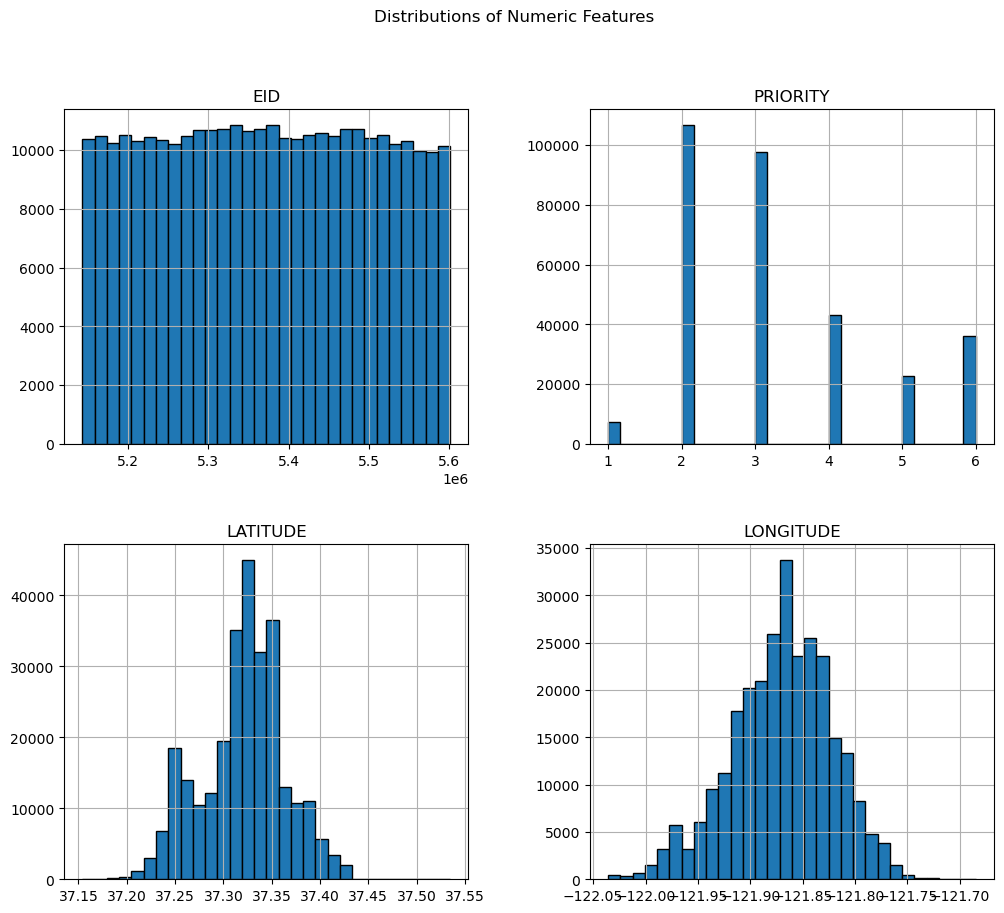

In [17]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [20]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE             370
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS             11866
CITY                    0
STATE                   0
LATITUDE            33110
LONGITUDE           33110
neighborhood        34651
dtype: int64

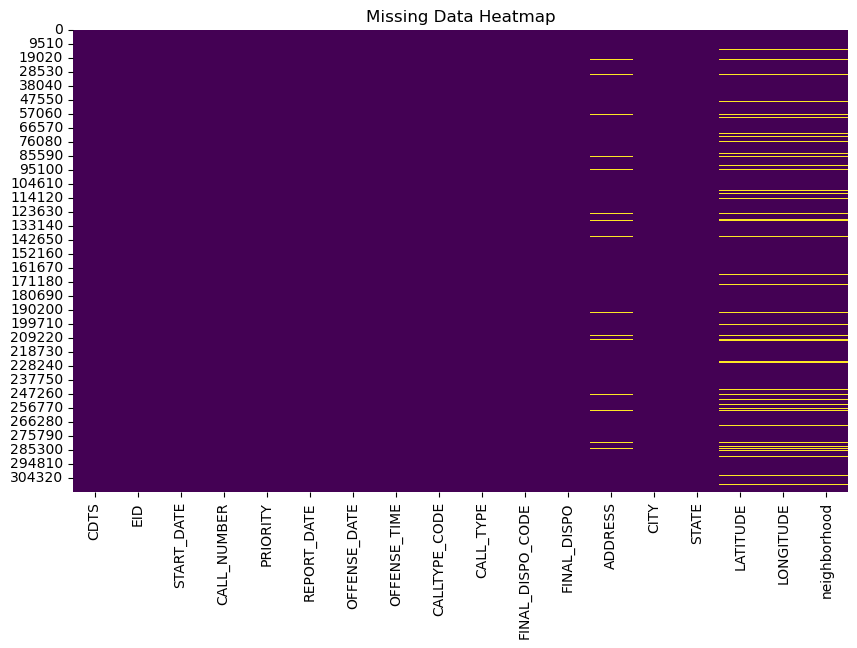

In [22]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [23]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 310969 unique values
START_DATE: 1 unique values
CALL_NUMBER: 303354 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 80499 unique values
CALLTYPE_CODE: 215 unique values
CALL_TYPE: 210 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31852 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [24]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      7933
Little Saigon and Spring Brook    5236
Trimble Business Area             4734
Five Wounds-San Jose High         4590
Fruitdale and Sherman Oaks        4427
                                  ... 
Los Alamitos Creek                  54
Meadowlands                         54
Linda Vista and Hillcrest           52
Villages                            46
Santa Teresa Hills                  42
Name: count, Length: 295, dtype: int64

In [25]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          125979
CAN         54456
R           33891
NR          20774
G           18136
A            8397
ADV          8119
GD           6477
E            6474
DUPNCAN      6297
H            5022
C            4358
T            3403
O            3248
B            2959
D            2481
U            1795
F            1264
M             140
P             107
TOT            20
Z               8
Name: count, dtype: int64

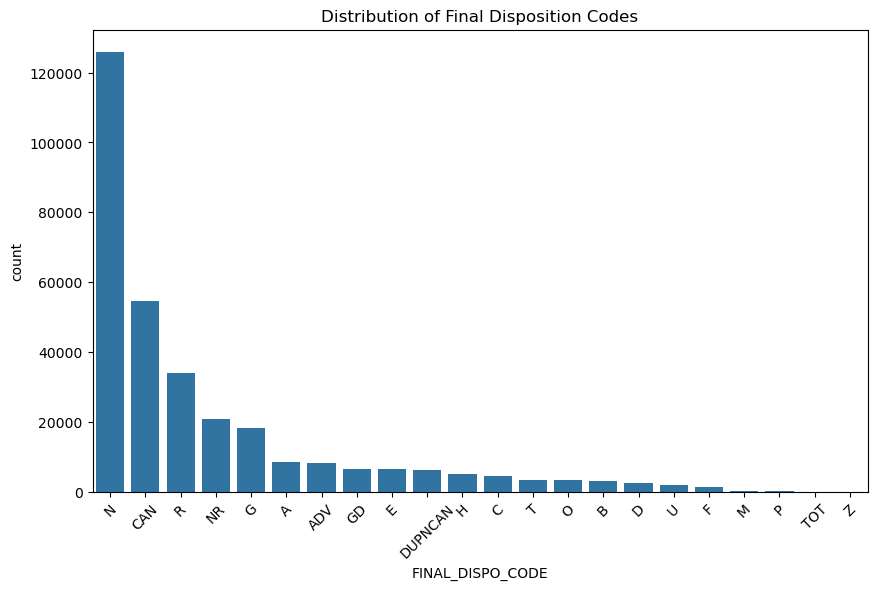

In [27]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [31]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    125979
Canceled                           54456
Report taken                       33891
No Disposition                     20921
No Response                        20774
Gone on Arrival/unable to loca     18136
Arrest Made                         8397
Traffic Citation Issued, Non-H      6474
Courtesy Service/Citizen or ag      5022
Criminal Citation                   4358
Turned over To (TOT)                3403
Supplemental report taken           3248
Arrest by Warrant                   2959
Traffic Citation Issued, Hazar      2481
Unfounded event                     1795
Field Interview (F.I.) Complet      1264
Stranded motorist assist             140
Prior case, follow-up activity       107
Name: count, dtype: int64

In [34]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'G': 'Gone on Arrival/unable to loca',
 'NR': 'No Response',
 'R': 'Report taken',
 'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'A': 'Arrest Made',
 'GD': 'No Disposition',
 'T': 'Turned over To (TOT)',
 'DUPNCAN': 'No Disposition',
 'H': 'Courtesy Service/Citizen or ag',
 'F': 'Field Interview (F.I.) Complet',
 'U': 'Unfounded event',
 'O': 'Supplemental report taken',
 'C': 'Criminal Citation',
 'ADV': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-H',
 'B': 'Arrest by Warrant',
 'D': 'Traffic Citation Issued, Hazar',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'Z': 'No Disposition',
 'TOT': 'No Disposition'}

In [36]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1066': 'SUSPICIOUS PERSON',
 '1033A': 'ALARM, AUDIBLE',
 '10851': 'STOLEN VEHICLE',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 '415': 'DISTURBANCE',
 '415M': 'DISTURBANCE, MUSIC',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 '10852': 'TAMPERING WITH A VEHICLE',
 'WELCK': 'WELFARE CHECK',
 '415A': 'DISTURBANCE, FIGHT',
 '1065MH': 'MISSING PERSON, MENTAL HANDICA',
 '23152': 'MISDEMEANOR DUI',
 '415N': 'DISTURBANCE, NEIGHBOR',
 '415F': 'DISTURBANCE, FAMILY',
 '415W': 'DISTURBANCE, WEAPON',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '242': 'BATTERY',
 '1053': 'PERSON DOWN',
 '23103': 'RECKLESS DRIVING',
 '1091': 'ANIMAL COMPLAINT',
 '148': 'RESISTING ARREST',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '459R': 'BURGLARY  REPORT  (460)',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '602PC': 'TRESPASSING',
 '647F': 'DRUNK IN PUBLIC',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1154':

## Focus on Target Dispositions

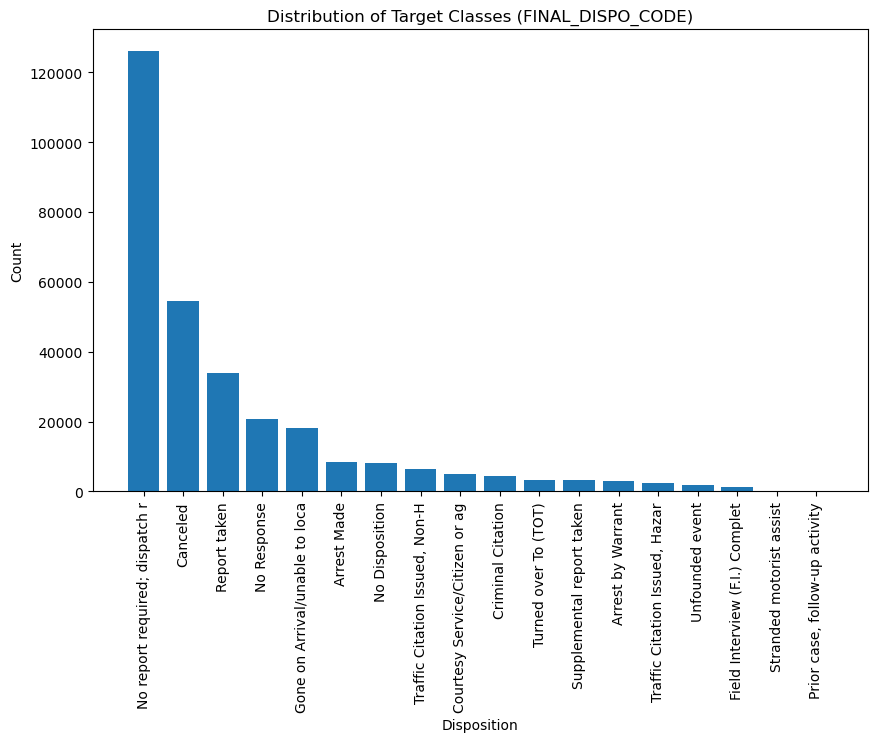

In [39]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [41]:
model_utils.transform_offense_date(all_police_df)

In [43]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    298091
A          8397
C          4358
B          2959
Name: count, dtype: int64

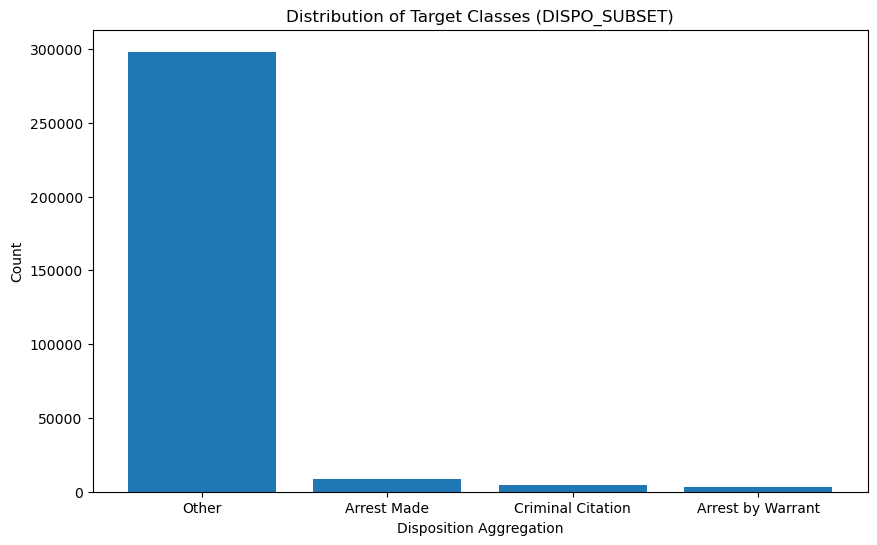

In [45]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [48]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 313805 rows before cleaning, 278837 rows after cleaning.


In [50]:
police_calls_encoded.shape

(278837, 15)

In [52]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,2,1066,1.354045,-0.207720,Berryessa Crossing,0,2,1,2014,No,Other,0.041437,1.833438,-0.281262,0.043148
1,3,1033A,-1.938602,2.354148,Shady Oaks and Basking Ridge,0,2,1,2014,No,Other,0.164539,3.758177,-4.563755,5.542013
2,3,10851,0.670235,0.288072,Little Portugal,0,2,1,2014,No,Other,0.032740,0.449215,0.193076,0.082985
3,4,415FC,-1.780675,1.325810,Blossom Valley,0,2,1,2014,No,Other,0.124065,3.170802,-2.360837,1.757773
4,2,1057,-1.578685,-0.648337,Branham,0,2,1,2014,No,Other,0.086910,2.492245,1.023520,0.420341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313799,2,SUSCIR,-0.162767,-0.183290,Goodyear Mastic,0,2,12,2014,No,Other,0.025943,0.026493,0.029834,0.033595
313801,3,594,0.131760,0.882600,Welch Park,0,2,12,2014,No,Other,0.060379,0.017361,0.116292,0.778983
313802,2,911CELL,-0.855803,1.048466,Hellyer,0,2,12,2014,No,Other,0.086502,0.732399,-0.897281,1.099281
313803,4,415FC,-0.860766,-0.339243,Willow Glen South,0,2,12,2014,No,Other,0.054767,0.740919,0.292009,0.115086


## Define X and Y

In [55]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [57]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(223069, 14)
(55768, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 211881, 0: 6033, 2: 3070, 1: 2085})
Counter({3: 11188, 0: 6033, 2: 3070, 1: 2085})


In [59]:
X_train.shape

(223069, 529)

In [61]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
89170,-1.647138,1.823269,-1.162176,0.365703,1.715481,-1.847965,0.240138,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163129,-0.168865,-1.544988,-1.447758,1.150164,1.019118,2.233647,0.752182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310426,-0.168865,-0.480030,0.554705,-0.055121,-0.567776,-0.110284,-0.475389,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306390,-0.168865,-0.617418,0.549668,0.059067,-0.456937,-0.178892,-0.479216,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113252,-0.908002,-1.792586,1.882576,2.433737,1.627482,-3.023697,1.749862,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210764,-0.168865,0.690558,0.907153,0.052092,-0.384194,0.727639,-0.121030,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301136,-0.168865,-1.433533,-0.283456,0.574560,0.774747,0.518911,-0.632257,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185894,2.048544,0.839514,-0.379241,-1.201939,-0.216031,-0.159500,-0.588702,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64059,-0.168865,-0.374329,0.540904,-0.155282,-0.634122,-0.050433,-0.485791,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


y_train distribution: Counter({3: 211881, 0: 6033, 2: 3070, 1: 2085})
y_test distribution: Counter({3: 52971, 0: 1508, 2: 768, 1: 521})
y_train_resampled distribution: Counter({3: 211881, 0: 6033, 2: 3070, 1: 2085})


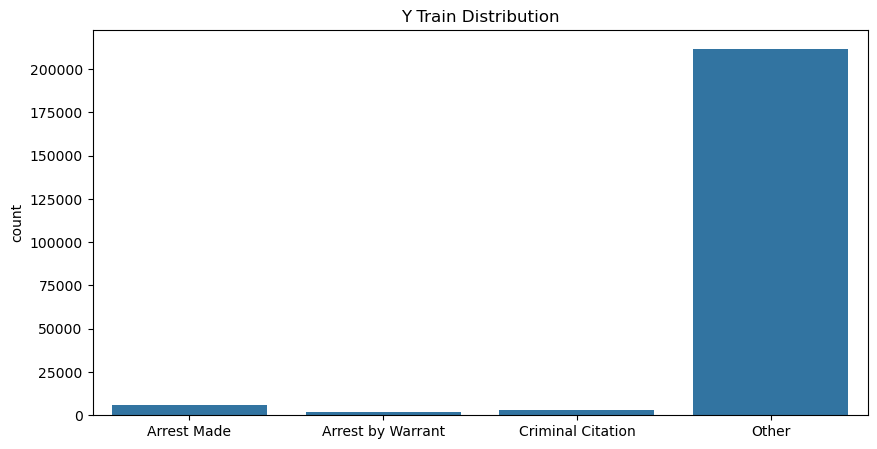

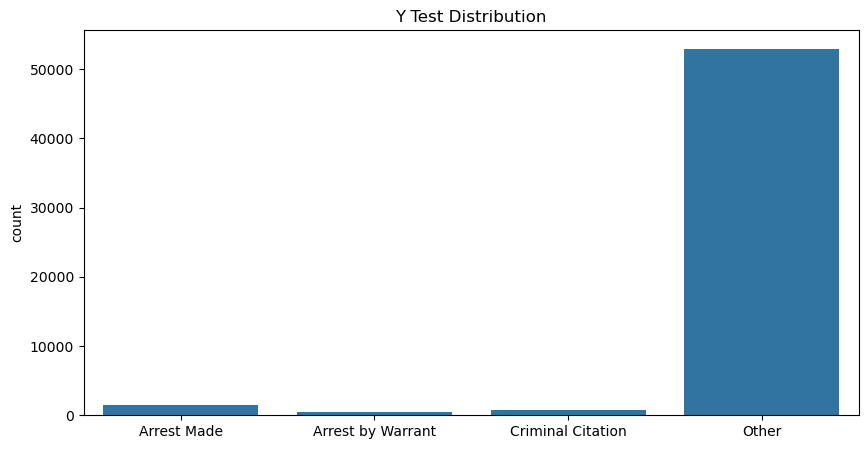

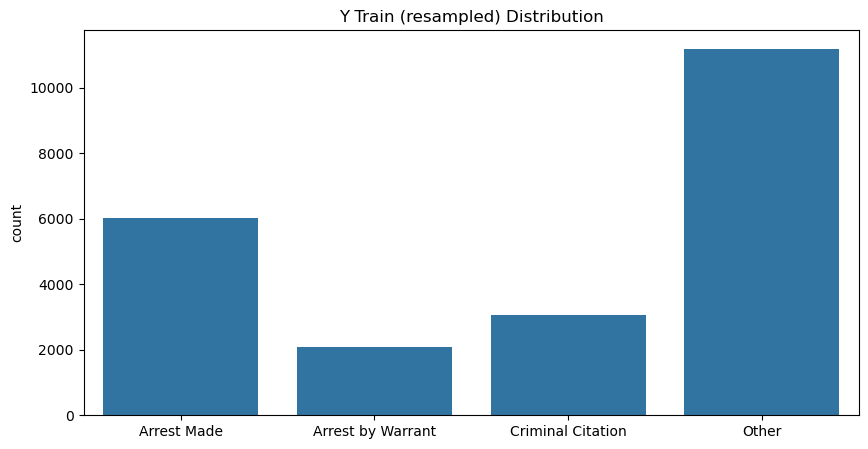

In [63]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [67]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [69]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [71]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1508
Arrest by Warrant       0.00      0.00      0.00       521
Criminal Citation       0.00      0.00      0.00       768
            Other       0.95      1.00      0.97     52971

         accuracy                           0.95     55768
        macro avg       0.24      0.25      0.24     55768
     weighted avg       0.90      0.95      0.93     55768



### Logistic Regression

In [74]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [75]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [76]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.29      0.74      0.41      1508
Arrest by Warrant       0.65      0.73      0.68       521
Criminal Citation       0.19      0.57      0.29       768
            Other       0.99      0.91      0.95     52971

         accuracy                           0.90     55768
        macro avg       0.53      0.74      0.58     55768
     weighted avg       0.95      0.90      0.92     55768



#### Hyperparameter Tuning

In [78]:
grid_search_scoring_method = 'f1_macro'

In [83]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [84]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.6449


In [85]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2014/best_logistic_regression.pkl']

In [86]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [87]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.71      0.48      0.57      1508
Arrest by Warrant       0.80      0.72      0.76       521
Criminal Citation       0.64      0.23      0.34       768
            Other       0.97      0.99      0.98     52971

         accuracy                           0.97     55768
        macro avg       0.78      0.60      0.66     55768
     weighted avg       0.96      0.97      0.96     55768



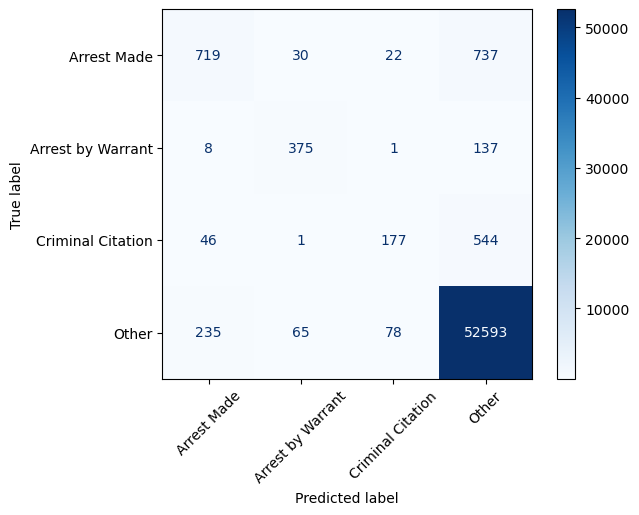

In [88]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [90]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [91]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [92]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.035775
2,PRIORITY,0.002391
1,neighborhood,0.002152
5,DISTANCE_FROM_CENTER,0.000598
4,LONGITUDE,0.000179
8,LONGITUDE^2,0.000149
7,LATITUDE LONGITUDE,0.000090
9,AFTER_COVID_Yes,0.000000
6,LATITUDE^2,-0.000179
3,LATITUDE,-0.000359


In [93]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [94]:
feature_names = X_train.columns

feature_display_names = []

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
        if call_type != '':
            feature_display_names.append("Call Type: " + call_type)
        else:
            feature_display_names.append(feature_name)
    else:
        call_types.append("")
        feature_display_names.append(feature_name)

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                          Feature  Importance  \
200                              CALLTYPE_CODE_6M    0.007472   
184                            CALLTYPE_CODE_601T    0.004364   
199                              CALLTYPE_CODE_6F    0.003288   
64                            CALLTYPE_CODE_11377    0.002959   
0                                        PRIORITY    0.002391   
67                            CALLTYPE_CODE_11550    0.001076   
8                             CALLTYPE_CODE_1033A    0.001016   
165                             CALLTYPE_CODE_484    0.000986   
63                            CALLTYPE_CODE_11357    0.000837   
84                            CALLTYPE_CODE_14601    0.000777   
65                           CALLTYPE_CODE_11377G    0.000747   
107                           CALLTYPE_CODE_23152    0.000717   
102                           CALLTYPE_CODE_22500    0.000717   
3                            DISTANCE_FROM_CENTER    0.000598   
18                       

In [95]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
184                   Call Type: TRUANT (TABS)     3.572010
65   Call Type: POSSESSION OF NARCOTICS, GANG      3.399864
107                 Call Type: MISDEMEANOR DUI     3.395250
61   Call Type: POSSESSION OF CONTROLLED SUBST     3.204366
64          Call Type: POSSESSION OF NARCOTICS     2.987594
198    Call Type: PETTY THEFT PRIOR CONVICTION     2.942353
62   Call Type: POSSESSION OF CONTROLLED SUBST     2.880357
108                      Call Type: FELONY DUI     2.720855
87   Call Type: RESISTING ARREST, GANG RELATED     2.651431
82      Call Type: CARRYING A CONCEALED WEAPON     2.526464
81    Call Type: ILLEGAL WEAPONS, GANG RELATED     2.476411
175       Call Type: MENTALLY DISTURBED PERSON     2.418262
151            Call Type: DISTURBANCE, UNKNOWN    -2.163432
196                 Call Type: DRUNK IN PUBLIC     2.155690
203     Call Type: UNK TYPE 911 CALL FROM CELL    -2.153712
67      Call Type: 

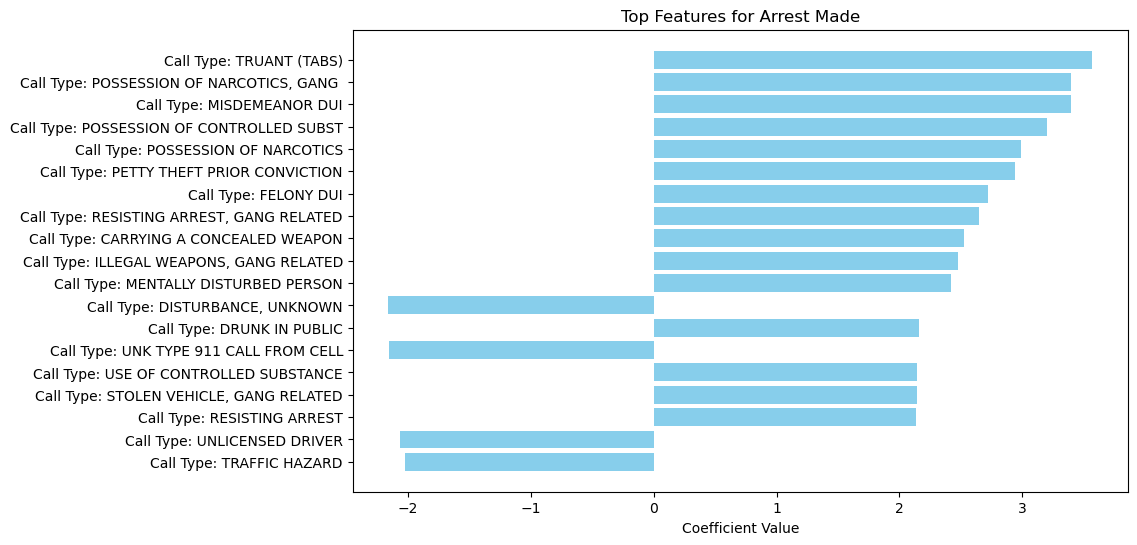

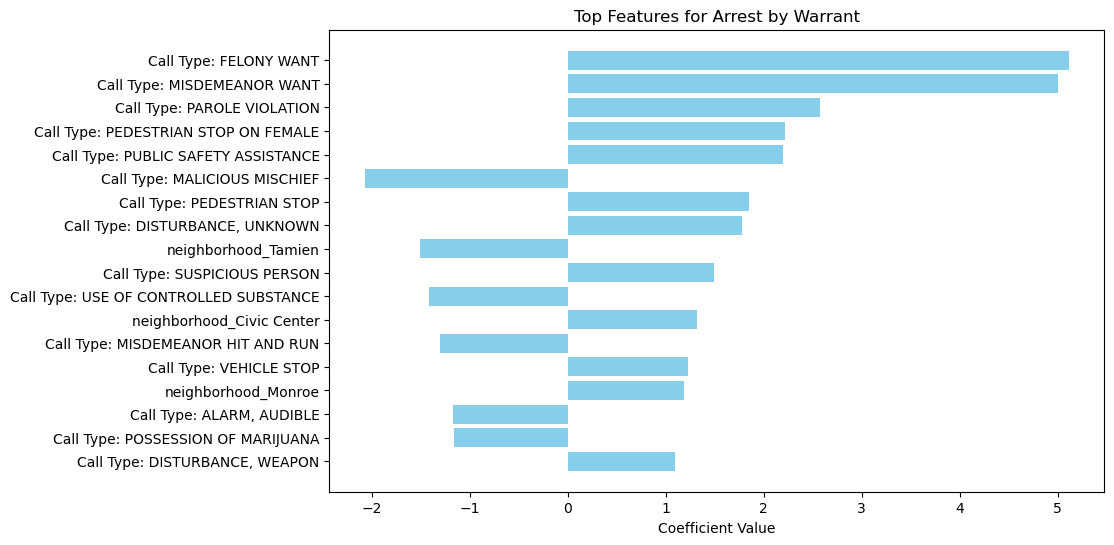

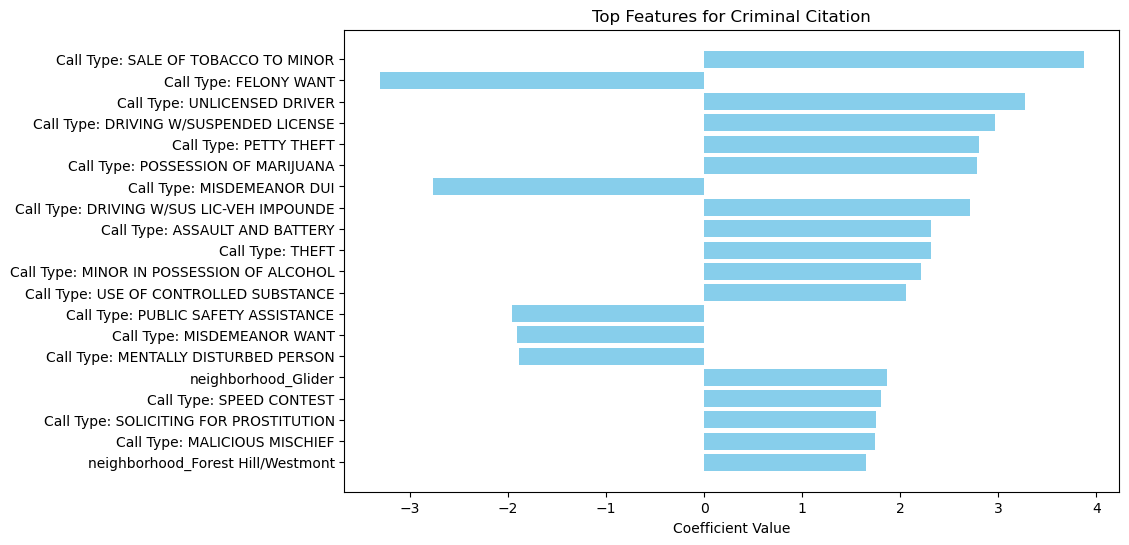

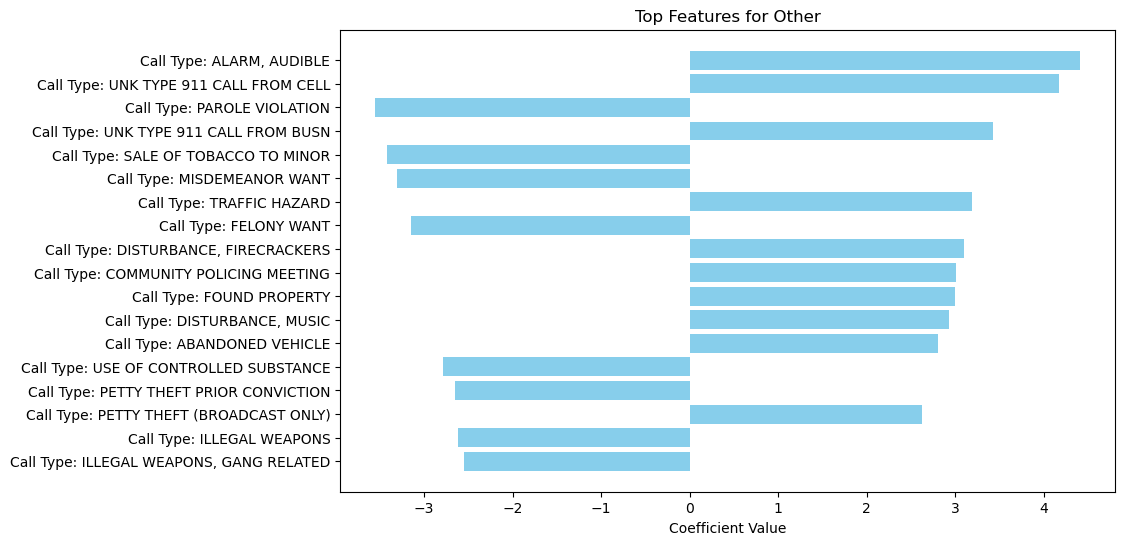

In [96]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [98]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [99]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.67      0.49      0.56      1508
Arrest by Warrant       0.74      0.65      0.69       521
Criminal Citation       0.56      0.31      0.40       768
            Other       0.97      0.99      0.98     52971

         accuracy                           0.96     55768
        macro avg       0.73      0.61      0.66     55768
     weighted avg       0.96      0.96      0.96     55768



#### Hyperparameter Tuning and Cross Validation

In [101]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.64


In [102]:
best_rf = grid_rf.best_estimator_

In [103]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2014/best_random_forest.pkl']

In [104]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [105]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.67      0.48      0.56      1508
Arrest by Warrant       0.73      0.65      0.69       521
Criminal Citation       0.54      0.30      0.39       768
            Other       0.97      0.99      0.98     52971

         accuracy                           0.96     55768
        macro avg       0.73      0.61      0.66     55768
     weighted avg       0.96      0.96      0.96     55768



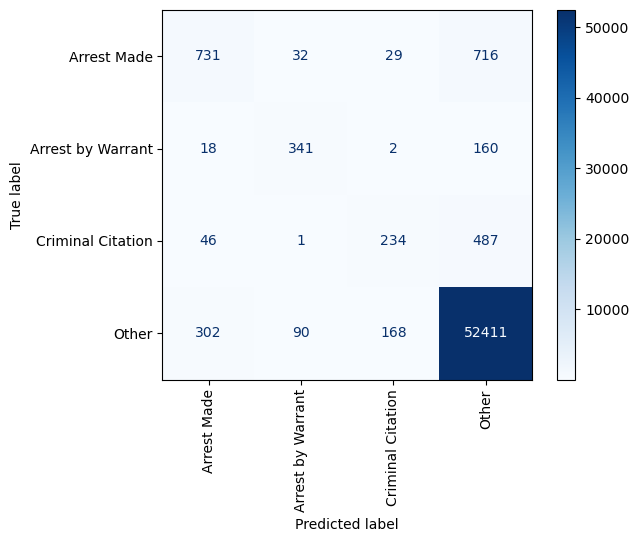

In [106]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [107]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-07 08:44:38,929] A new study created in memory with name: no-name-74e778b9-bbc5-4430-89f6-3e9c13f85317
[I 2024-10-07 08:44:41,264] Trial 0 finished with value: 0.748592490831946 and parameters: {'n_estimators': 87, 'max_depth': 85, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.748592490831946.
[I 2024-10-07 08:44:42,627] Trial 1 finished with value: 0.7192056326117665 and parameters: {'n_estimators': 88, 'max_depth': 58, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.748592490831946.
[I 2024-10-07 08:44:44,046] Trial 2 finished with value: 0.7185818465057009 and parameters: {'n_estimators': 71, 'max_depth': 37, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.748592490831946.
[I 2024-10-07 08:44:46,206] Trial 3 finished with value: 0.7348249003703101 and parameters: {'n_estimators': 94, 'max_depth': 33, 'min_sa

Best hyperparameters: {'n_estimators': 99, 'max_depth': 74, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [108]:
best_params = study.best_params
best_params

{'n_estimators': 99,
 'max_depth': 74,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'sqrt'}

In [109]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=74, min_samples_split=20, n_estimators=99,
                       n_jobs=-1)

In [110]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.75      0.50      0.60      1508
Arrest by Warrant       0.80      0.72      0.76       521
Criminal Citation       0.66      0.27      0.38       768
            Other       0.97      0.99      0.98     52971

         accuracy                           0.97     55768
        macro avg       0.80      0.62      0.68     55768
     weighted avg       0.96      0.97      0.96     55768



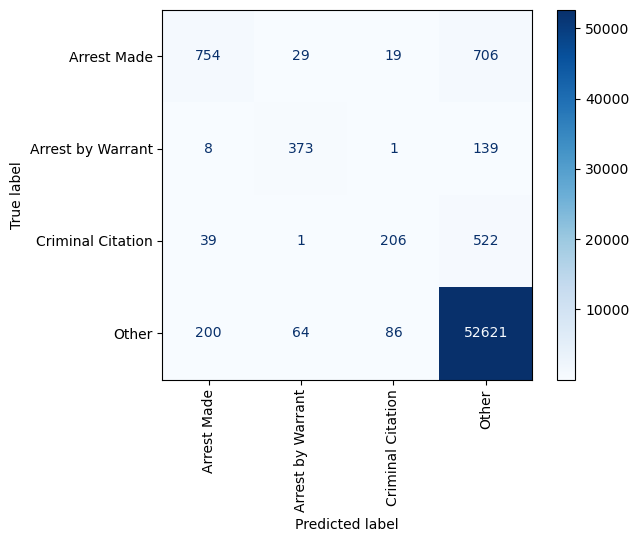

In [111]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

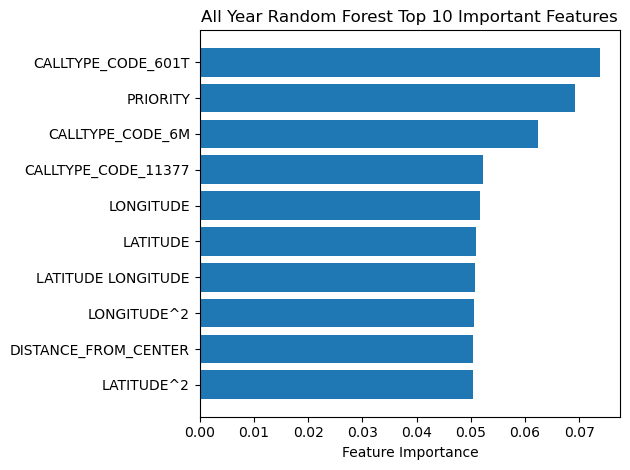

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title(f'{year} Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig(f'images/{year}_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [115]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [116]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [117]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9565 - loss: 0.1897 - val_accuracy: 0.9677 - val_loss: 0.1213
Epoch 2/20
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9652 - loss: 0.1311 - val_accuracy: 0.9687 - val_loss: 0.1179
Epoch 3/20
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9663 - loss: 0.1237 - val_accuracy: 0.9685 - val_loss: 0.1198
Epoch 4/20
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9664 - loss: 0.1218 - val_accuracy: 0.9685 - val_loss: 0.1180
Epoch 5/20
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9666 - loss: 0.1174 - val_accuracy: 0.9682 - val_loss: 0.1202


In [118]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2014/mlp_model.pkl']

In [119]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [120]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1743/1743 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.9669 - loss: 0.1242
Test Accuracy: 0.9673


In [121]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1743/1743 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.73      0.50      0.60      1508
Arrest by Warrant       0.80      0.72      0.75       521
Criminal Citation       0.63      0.28      0.38       768
            Other       0.98      0.99      0.98     52971

         accuracy                           0.97     55768
        macro avg       0.78      0.62      0.68     55768
     weighted avg       0.96      0.97      0.96     55768



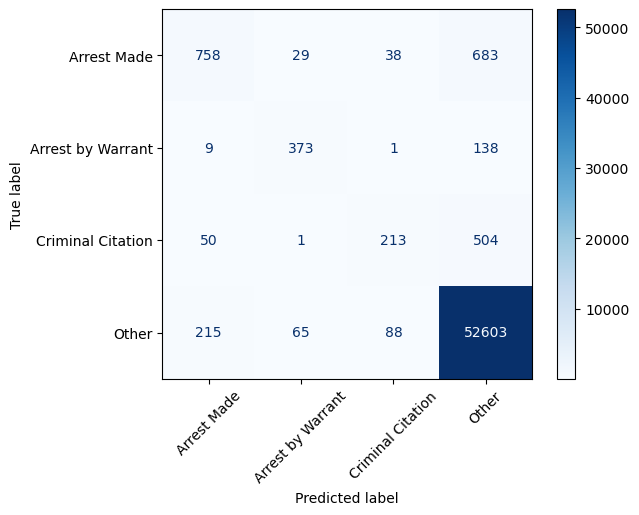

In [122]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [125]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 30

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-07 08:46:12,618] A new study created in memory with name: no-name-85f4bfd1-a390-492f-bfea-8f000eb9897c
[I 2024-10-07 08:46:44,736] Trial 0 finished with value: 0.7343743980164051 and parameters: {'learning_rate': 0.00736356650725941, 'max_depth': 10, 'subsample': 0.695897372743916, 'colsample_bytree': 0.7452596071423034, 'gamma': 0.00018360586621781678, 'reg_alpha': 8.389440225560819e-07, 'reg_lambda': 0.0005777310637210153}. Best is trial 0 with value: 0.7343743980164051.
[I 2024-10-07 08:47:07,465] Trial 1 finished with value: 0.7467585622584985 and parameters: {'learning_rate': 0.24293924422873334, 'max_depth': 9, 'subsample': 0.9428417445134533, 'colsample_bytree': 0.7989769515440942, 'gamma': 8.444035869417966e-07, 'reg_alpha': 1.0718462715957713e-08, 'reg_lambda': 0.0016763706362831656}. Best is trial 1 with value: 0.7467585622584985.
[I 2024-10-07 08:47:36,648] Trial 2 finished with value: 0.7156180988528043 and parameters: {'learning_rate': 0.0010058263917730884, 'ma

Actual runtime: 780.85 seconds (13.01 minutes)
Best parameters found:  {'learning_rate': 0.09890174584433264, 'max_depth': 5, 'subsample': 0.7357841266545988, 'colsample_bytree': 0.9427085223850236, 'gamma': 0.9600367589314787, 'reg_alpha': 0.001358109720862881, 'reg_lambda': 2.2989288528702317e-06}
Best F1 macro score:  0.7601377460134213


In [126]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9427085223850236, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.9600367589314787, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09890174584433264,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [127]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.78      0.46      0.57      1508
Arrest by Warrant       0.80      0.71      0.75       521
Criminal Citation       0.71      0.19      0.30       768
            Other       0.97      0.99      0.98     52971

         accuracy                           0.97     55768
        macro avg       0.81      0.59      0.65     55768
     weighted avg       0.96      0.97      0.96     55768



In [128]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2014/xgb_model.pkl']

In [129]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [131]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [132]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.6623086922441479
RF F1: 0.6563186422520976
XGB F1: 0.6525599484722601


In [133]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [134]:
best_rf

RandomForestClassifier(n_estimators=60)

In [135]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9427085223850236, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.9600367589314787, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09890174584433264,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [136]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [137]:
X_train_float = X_train.astype('float64')

In [138]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9427085223850236,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [139]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2014/stacking_2.pkl']

In [140]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [141]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6869276130993258


In [142]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.72      0.55      0.62      1508
Arrest by Warrant       0.80      0.71      0.75       521
Criminal Citation       0.64      0.28      0.39       768
            Other       0.98      0.99      0.98     52971

         accuracy                           0.97     55768
        macro avg       0.78      0.63      0.69     55768
     weighted avg       0.96      0.97      0.96     55768



## Results

In [144]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.949846,0.250000,0.237461,0.243569
Logistic Regression,0.965859,0.604973,0.779977,0.662309
Random Forest,0.963223,0.608344,0.729086,0.656319
MLP,0.967347,0.622245,0.783351,0.679947
XGB,0.966522,0.587989,0.814937,0.652560
Ensemble,0.967616,0.633448,0.781232,0.686928


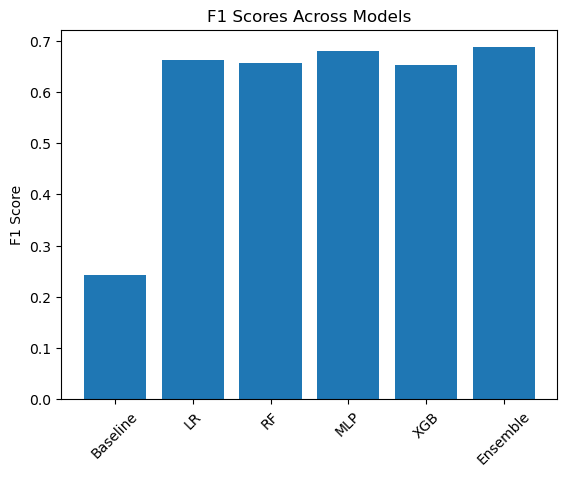

In [145]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [147]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [148]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

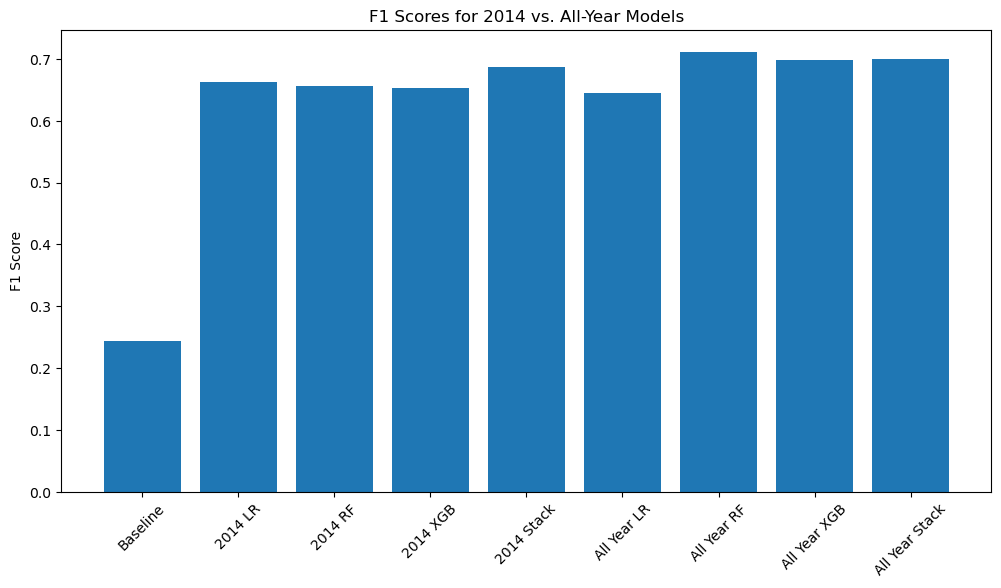

In [149]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2014 vs. Non-2014 Models

In [151]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [152]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(313805, 24)

In [153]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3273052 rows before cleaning, 2921599 rows after cleaning.


(2921599, 15)

In [154]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2337279, 14)
(584320, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2244918, 0: 46562, 2: 25611, 1: 20188})
Counter({3: 92361, 0: 46562, 2: 25611, 1: 20188})


In [155]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [156]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2014 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.53      0.34      0.41     11641
Arrest by Warrant       0.68      0.52      0.59      5047
Criminal Citation       0.45      0.22      0.30      6403
            Other       0.98      0.99      0.98    561229

         accuracy                           0.97    584320
        macro avg       0.66      0.52      0.57    584320
     weighted avg       0.96      0.97      0.96    584320



In [157]:
y_pred_rf_oy_2014 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2014, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2014 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.69      0.49      0.57      1508
Arrest by Warrant       0.79      0.66      0.72       521
Criminal Citation       0.56      0.22      0.32       768
            Other       0.97      0.99      0.98     52971

         accuracy                           0.96     55768
        macro avg       0.75      0.59      0.65     55768
     weighted avg       0.96      0.96      0.96     55768



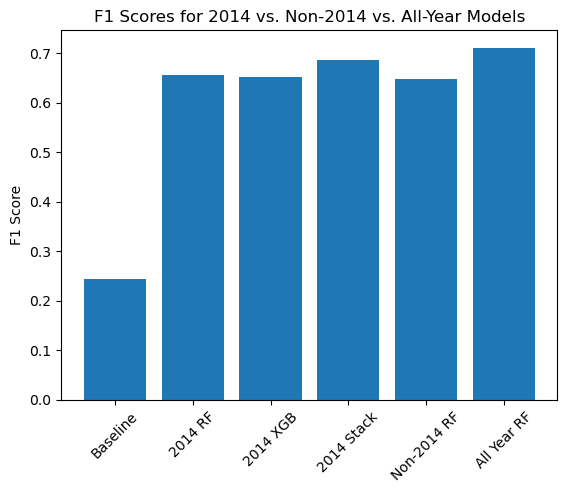

In [158]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2014, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()